In [1]:
import netgen.gui
from netgen.csg import *
from ngsolve import *
from ngsolve.solvers import CG

import matplotlib.pyplot as plt
import numpy as np

from ngsolve.internal import visoptions
from ngsolve.internal import viewoptions

In [14]:
def MakeGeometry():
    geometry = CSGeometry()
    box = OrthoBrick(Pnt(-1,-1,-1),Pnt(2,1,2)).bc("outer")

    core = OrthoBrick(Pnt(0,-0.05,0),Pnt(0.8,0.05,1))- \
           OrthoBrick(Pnt(0.1,-1,0.1),Pnt(0.7,1,0.9))- \
           OrthoBrick(Pnt(0.5,-1,0.4),Pnt(1,1,0.6)).maxh(0.2).mat("core")
    
    coil = (Cylinder(Pnt(0.05,0,0), Pnt(0.05,0,1), 0.3) - \
            Cylinder(Pnt(0.05,0,0), Pnt(0.05,0,1), 0.15)) * \
            OrthoBrick (Pnt(-1,-1,0.3),Pnt(1,1,0.7)).maxh(0.2).mat("coil")
    
    geometry.Add ((box-core-coil).mat("air"))
    geometry.Add (core)
    geometry.Add (coil)
    return geometry

ngmesh = MakeGeometry().GenerateMesh(maxh=0.5)
mesh = Mesh(ngmesh)

#ngsglobals.msg_level = 5

fes = HCurl(mesh, order=1, dirichlet="outer")

u = fes.TrialFunction()
v = fes.TestFunction()

mur = { "core" : 1000, "coil" : 1, "air" : 1 }
mu0 = 1.257e-6

nu_coef = [ 1/(mu0*mur[mat]) for mat in mesh.GetMaterials() ]
print ("nu_coef=", nu_coef)
epsilon = []
for j in range(7):
    epsilon.append(10**(-j))

nu_coef= [795544.9482895783, 795.5449482895783, 795544.9482895783]


In [3]:
blocks = []
freedofs = fes.FreeDofs()
for v in mesh.vertices:
    vdofs = set()
    for el in mesh.vertices:
        vdofs |= set(d for d in fes.GetDofNrs(el) if freedofs[d])
    blocks.append(vdofs)

In [22]:
err_jac = np.zeros([10000,14])
err_block = np.zeros([10000,14])
temp = []
n = 1
for eps in epsilon:
    nu = CoefficientFunction(nu_coef)

    a = BilinearForm(fes, symmetric=True)
    a += nu*curl(u)*curl(v)*dx + eps*nu*u*v*dx

    # the jacobi preconditioner
    c = Preconditioner(a, type="local")
    # the direct inverse 
    # c = Preconditioner(a, type="direct")

    f = LinearForm(fes)
    f += CoefficientFunction((y,0.05-x,0)) * v * dx("coil")

    #blocks = []
    blocks = []
    freedofs = fes.FreeDofs()
    for ver in mesh.vertices:
        vdofs = set()
        for el in mesh[ver].edges:
            vdofs |= set(d for d in fes.GetDofNrs(el) if freedofs[d])
        blocks.append(vdofs)
    # create your blocks here

    gfu = GridFunction(fes)

    # stores the error and iteration number
    data_jac = []
    data_block = []
    #AFW = a.CreateBlockSmoother(blocks)
    # needed for this...
    callback_jac = lambda k_jac,r_jac: data_jac.append((k_jac,r_jac))
    callback_block = lambda k_block,r_block: data_block.append((k_block,r_block))

    with TaskManager():
        a.Assemble()    
        f.Assemble()
        AFW = a.mat.CreateBlockSmoother(blocks)
        solvers.CG(mat=a.mat, pre=c.mat, sol = gfu.vec, rhs = f.vec, tol = 1e-8, maxsteps = 10000, callback = callback_jac, printrates = False)
        #print(data [-1])
        # Use your AFW preconditioner instead of the Jacobi
        solvers.CG(mat=a.mat, pre=AFW, sol = gfu.vec, rhs = f.vec, tol = 1e-8, maxsteps = 10000, callback = callback_block, printrates = False)



    #d = []
    for i in range(len(data_jac)):
        #d.append(data[i][0])
        #temp.append(data[i][1])
        err_jac[i,n-1] = data_jac[i][0]
        err_jac[i,n] = data_jac[i][1]
        #print("i",i)

    for i in range(len(data_block)):
        #d.append(data[i][0])
        #temp.append(data[i][1])
        err_block[i,n-1] = data_block[i][0]
        err_block[i,n] = data_block[i][1]

    print("epsilon: ",eps)
    n = n + 2
    #print("i",i)
    #print("j",j)


epsilon:  1
epsilon:  0.1
epsilon:  0.01
epsilon:  0.001
epsilon:  0.0001
epsilon:  1e-05
epsilon:  1e-06


In [ ]:
err_jac[:,13]

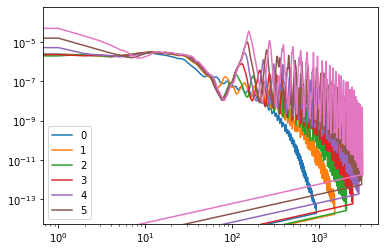

In [23]:
n = 1
for j in range(7):
    plt.loglog(err_jac[:,n-1],err_jac[:,n])
    plt.legend(range(j))
    n = n + 2

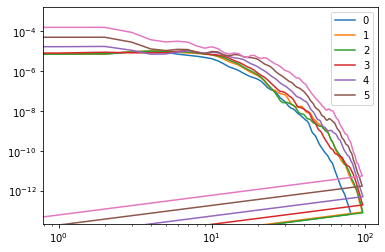

In [24]:
n = 1
for j in range(7):
    plt.loglog(err_block[:,n-1],err_block[:,n])
    plt.legend(range(j))
    n = n + 2